# Introduction

The notebook is a step-by-step tutorial on using Transformer models for Natural Language Inferencing (NLI). This includes how to load, fine-tune, and evaluate M-BERT and XLM-RoBERTa models with Tensorflow.

Natural Language Inferencing (NLI) is an exciting NLP (Natural Language Processing) problem to identify the semantic relationship between two sentences. Given a hypothesis and premise sentence-pairs, the task is to determine whether the premise `entails` the hypothesis statement, `contradicts` it, or neither (`neutral`). 

For more information on the problem, you can visit [Contradictory, My Dear Watson competition](https://www.kaggle.com/c/contradictory-my-dear-watson/overview)

# Load Libraries and Dependencies

In [1]:
!pip install --upgrade pip
!pip install --upgrade allennlp
!pip install transformers==4.3.0

     |████████████████████████████████| 1.8 MB 868 kB/s 
  Attempting uninstall: transformers
    Found existing installation: transformers 4.4.2
    Uninstalling transformers-4.4.2:
      Successfully uninstalled transformers-4.4.2


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [3]:
from transformers import BertTokenizer, TFBertModel
from tokenizers import BertWordPieceTokenizer
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    
from transformers import (XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel)            

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import classification_report, f1_score, accuracy_score

os.environ["WANDB_API_KEY"] = "0" # to silence warning

np.random.seed(0)

# Configure TPU Settings

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 8


# Load CSV Data files with Pandas

The dataset contains train and test files that includes premise-hypothesis pairs in fifteen different languages. 

The classification of the relationship between the premise and hypothesis statements is as follows:

- label==`0` for `entailment`
- label==`1` for `neutral`
- label==`2` for `contradiction`

You can look at [competition website](https://www.kaggle.com/c/contradictory-my-dear-watson/data) for elaboration on the dataset.

In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


# Data Exploration and Analysis

Explore data & drop any incomplete rows of data.

Find how many data points and features are in the original, provided training dataset.

In [6]:
# print out stats about data

missing_values_count = train.isnull().sum() # we get the number of missing data points per column
print("Number of missing data points per column:\n")
print (missing_values_count)

Number of missing data points per column:

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64


In [7]:
# check the number of rows and columns in the training set

print("Number of training data rows: {} \n".format(train.shape[0]))

print("Number of training data columns: {} \n".format(train.shape[1]))

Number of training data rows: 12120 

Number of training data columns: 6 



Let's look at the distribution of languages in the training set.

In [8]:
train.language.unique()
train.language.value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
German         351
Turkish        351
Bulgarian      342
Name: language, dtype: int64

Let's now visualize the distribution of class labels over the training data

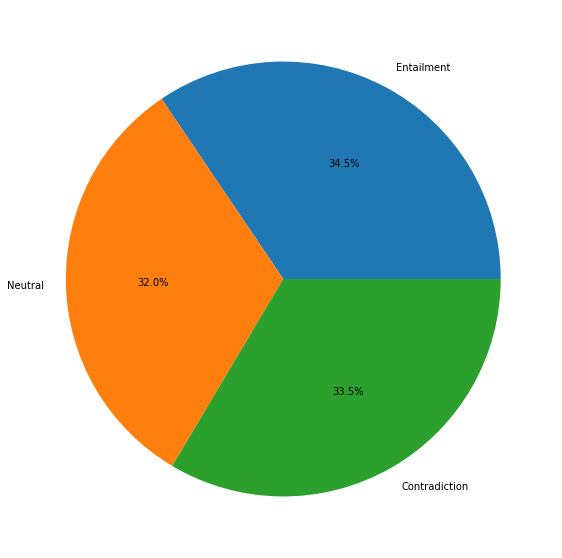

In [9]:
# counts for all classes
counts = train['label'].value_counts()

class_labels = ['Entailment', 'Neutral', 'Contradiction']

counts_per_class = [counts[0], counts[1], counts[2]]

# counts.plot(kind='barh')

plt.figure(figsize = (10,10))
plt.pie(counts_per_class,labels = class_labels, autopct = '%1.1f%%')
plt.show()

From the chart above, we can see that the training data is fairly balanced over the 3 classes.

# Split the Training Data

We will be splitting the training dataset into two parts - the data we will train the model with and a validation set. We stratify data during train-valid split to preserve the original distribution of the target classes.

In [10]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, stratify=train.label.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)


train.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

In [11]:
# check the number of rows and columns after split

print("Train data: {} \n".format(train.shape))

print("Validation data: {} \n".format(validation.shape))

Train data: (9696, 6) 

Validation data: (2424, 6) 



# Implement M-BERT Model

The Multilingual BERT or M-BERT is a single language model pre-trained on the concatenation of monolingual Wikipedia corpora from 104 languages. We will fine-tune this pretrained model on our training dataset to get the predictions for textual entailment recognition.

## Set up M-BERT Tokenizer

A pretrained model only performs properly if we feed it an input that was tokenized with the same rules that were used to tokenize its training data. The BERT multilingual model does not perform any normalization on the input (no lower casing, accent stripping, or Unicode normalization). Hence we also follow the same rules when tokenizing input data for our task. For more information on data pre-processing, visit [M-BERT github](https://github.com/google-research/bert/blob/master/multilingual.md).

In [12]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name) # Save the slow pretrained tokenizer
save_path = '.'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path) # Save the loaded tokenizer locally
tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=False, strip_accents=False) # Load the fast tokenizer from saved file

tokenizer

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=False, lowercase=False, wordpieces_prefix=##)

Let's look at the sequence length distribution (e.g. number of tokens in a sequence) for the input data. We will need this information later when setting the `max_len` value since a machine learning algorithm requires all the inputs in a batch to have the same length.

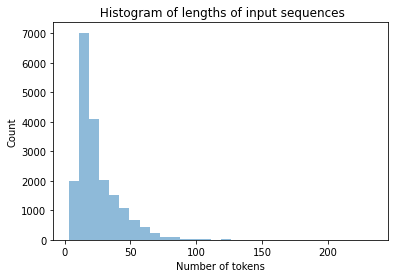

In [13]:
def plot(df, tokenizer):
    """
    Plot histogram of lengths of input sequences
    """
    all_text = df.premise.values.tolist() + df.hypothesis.values.tolist() # list of string texts
    all_text_tokenized = tokenizer.encode_batch(all_text) # list of encoding objects
    all_tokenized_len = [len(encoding.tokens) for encoding in all_text_tokenized] # list of token lengths
       
    plt.hist(all_tokenized_len, bins=30, alpha=0.5)
    plt.title(' Histogram of lengths of input sequences')
    plt.xlabel('Number of tokens')
    plt.ylabel('Count')

    plt.show()

plot(train, tokenizer)

From the histogram above, we can see that majority of the input sequences have less than 50 tokens.

We can also calculate the mean and max input sequence lengths per language.

In [14]:
tokenized_premise = tokenizer.encode_batch(train.premise.values.tolist()) # list of encoding objects
train['premise_seq_length'] = [len(encoding.tokens) for encoding in tokenized_premise] # list of lengths
    
tokenized_hypothesis = tokenizer.encode_batch(train.hypothesis.values.tolist()) # list of encoding objects
train['hypothesis_seq_length'] = [len(encoding.tokens) for encoding in tokenized_hypothesis] # list of lengths

# Calculate max and avg sequence length per language
info_per_lang = train.groupby('language').agg({'premise_seq_length': ['mean', 'max', 'count'], 'hypothesis_seq_length': ['mean', 'max', 'count']})
print (info_per_lang)

           premise_seq_length            hypothesis_seq_length          
                         mean  max count                  mean max count
language                                                                
Arabic              36.375776   96   322             18.776398  65   322
Bulgarian           40.114391   89   271             20.619926  56   271
Chinese             33.707792   76   308             17.113636  47   308
English             28.039703  234  5516             15.045323  61  5516
French              32.851964   74   331             18.078550  41   331
German              30.721831   69   284             16.169014  34   284
Greek               50.888136  109   295             26.366102  61   295
Hindi               42.878472   99   288             22.871528  51   288
Russian             36.202128   88   282             19.060284  54   282
Spanish             29.770318   62   283             16.070671  47   283
Swahili             35.964856   88   313           

From the above table, we can see that the length of premise sentences are greater than those of the hypothesis sentences for all languages. 

Hence, let's visualize the mean sequence length distribution over the languages for the premise inputs.

<AxesSubplot:xlabel='language'>

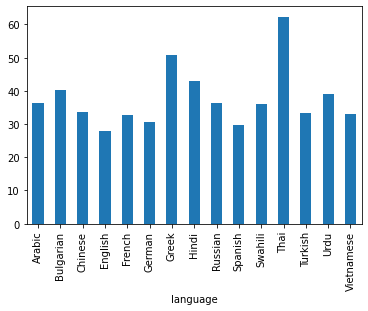

In [15]:
column_name = info_per_lang.columns.values[0] #premise mean column
info_per_lang[column_name].plot(kind='bar')

The length should be large enough such that we don’t lose much data. Additionally, a very big number would make the model complex.

Since most of the inputs are shorter than 50 words, we can consider length 50 for each input type of hypothesis and premise. 

Hence we set `MAX_LEN`=100.

*Note*: The `MAX_LEN` hyperparameter can be taken as a parameter to be tuned to get optimal results.

## Configure Hyperparameter Settings

In [16]:
# Configuration
EPOCHS = 3
BATCH_SIZE = 64 
MAX_LEN = 100
PATIENCE = 1
LEARNING_RATE = 1e-5

## Encode Input Sequences

For BERT model, the input is represented in the following format:

`CLS` Premise `SEP` Hypothesis `SEP`

The `CLS` and `SEP` are special tokens, where `CLS` is used in the beginning of a sequence for sentence-level classification while `SEP` separates the sentence pairs.

We encode the training data by vectorizing the input strings and applying padding and truncation using `MAX_LEN` value.

The encoded input will include - input word IDs, input masks, and input type IDs

In [17]:
def encode(df, tokenizer, max_len=50):
    
    pairs = df[['premise','hypothesis']].values.tolist()

    tokenizer.enable_truncation(max_len)
    tokenizer.enable_padding()
    
    print ("Encoding...")
    # We'll use encode_batch() as 'BertWordPieceTokenizer' object has no attribute 'batch_encode_plus'
    enc_list = tokenizer.encode_batch(pairs)
    print ("Complete")
    
    input_word_ids = tf.ragged.constant([enc.ids for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.ragged.constant([enc.attention_mask for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len]
    input_type_ids = tf.ragged.constant([enc.type_ids for enc in enc_list], dtype=tf.int32) #shape=[num_examples, max_len]
   
    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask.to_tensor(),
        'input_type_ids': input_type_ids.to_tensor()}
    
    return inputs 

In [18]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [19]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


## Create and Train Model

We extract the pretrained BERT embedding vectors of the `CLS` token in the last layer and pass that as input to the classification layer for further training.

In [20]:
def build_model(model_name, max_len=50):
    
    tf.random.set_seed(12345) # For reproducibility
    
    bert_encoder = TFBertModel.from_pretrained(model_name)
#     bert_encoder = TFAutoModel.from_pretrained(model_name)

    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0] # shape=(batch_size, max_len, embed_size)
    cls_vector = embedding[:,0,:] #shape=(batch_size, embed_size)
    output = tf.keras.layers.Dense(3, activation='softmax')(cls_vector) # shape=[batch_size, num_class=3]       
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = build_model(model_name, MAX_LEN)
    model.summary()

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

The model will be trained on the training subset and early-stopping will be applied on validation subset to avoid overfitting. The best model checkpoint will be saved after `EPOCHS` iterations.

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath='bert_best_checkpoint.hdf5'

# callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)]
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]

train_history = model.fit(x=train_input, y=train.label.values, validation_data=(validation_input, validation.label.values), epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/3
152/152 [==============================] - 131s 419ms/step - loss: 1.0779 - accuracy: 0.4176 - val_loss: 0.8655 - val_accuracy: 0.6167

Epoch 00001: val_loss improved from inf to 0.86545, saving model to bert_best_checkpoint.hdf5
Epoch 2/3
152/152 [==============================] - 13s 85ms/step - loss: 0.7945 - accuracy: 0.6496 - val_loss: 0.8371 - val_accuracy: 0.6324

Epoch 00002: val_loss improved from 0.86545 to 0.83712, saving model to bert_best_checkpoint.hdf5
Epoch 3/3
152/152 [==============================] - 13s 85ms/step - loss: 0.6219 - accuracy: 0.7430 - val_loss: 0.8958 - val_accuracy: 0.6353

Epoch 00003: val_loss did not improve from 0.83712
Epoch 00003: early stopping


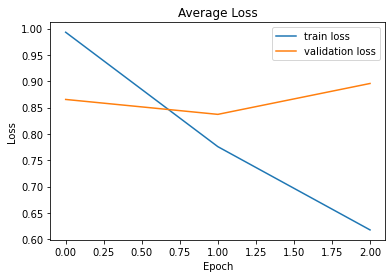

In [23]:
# plot loss history
plt.plot(train_history.history['loss'], label='train loss')
plt.plot(train_history.history['val_loss'], label='validation loss')
plt.title('Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

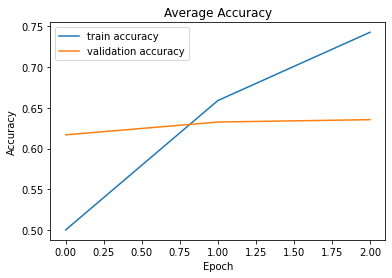

In [24]:
# plot accuracy history
plt.plot(train_history.history['accuracy'], label='train accuracy')
plt.plot(train_history.history['val_accuracy'], label='validation accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the above plots, we can see that there is a huge gap between the training and validation losses, which suggests that the M-BERT model is not quite good at generalizing to unseen data. The M-BERT model gives final validation accuracy of around 64%. In the next section, we'll look at another model, namely XLM-RoBERTa, which improves the validation accuracy and is much better at predictions on new data.  

In [25]:
del model #to free up space

In [26]:
# Resets all state generated by Keras
K.clear_session()

# Implement XLM-RoBERTa Model

The XLM-RoBERTa is based on Facebook’s RoBERTa model released in 2019. It is a large multi-lingual language model, trained on 2.5TB of filtered CommonCrawl data.

## Set up the Tokenizer

In [27]:
PRETRAINED_MODEL_TYPES = {
    'xlmroberta': (XLMRobertaConfig, TFXLMRobertaModel, XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-large')
}

config_class, model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['xlmroberta']

# Download vocabulary from huggingface.co and cache.
# tokenizer = tokenizer_class.from_pretrained(model_name) 
tokenizer = AutoTokenizer.from_pretrained(model_name) #fast tokenizer

tokenizer

Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='jplu/tf-xlm-roberta-large', vocab_size=250002, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

## Encode Input Sequences

The encoded input will include - input word IDs and input masks, as required by the XLM-RoBERTa model.

In [28]:
def encode(df, tokenizer, max_len=50):
    
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True, 
                                               add_special_tokens=True, return_attention_mask=True)
    print ("Complete")
    
    input_word_ids = tf.convert_to_tensor(encoded_dict['input_ids'], dtype=tf.int32) #shape=[num_examples, max_len])
    input_mask = tf.convert_to_tensor(encoded_dict['attention_mask'], dtype=tf.int32) #shape=[num_examples, max_len]
    
    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask}    
    
    return inputs

We will use the same train-validation split and hyperparameter settings as in the previous BERT model for results to be comparable.

In [29]:
train_input = encode(train, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [30]:
validation_input = encode(validation, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


## Create and Train Model

In [31]:
def build_model(max_len=50):
    
    tf.random.set_seed(12345) # For reproducibility
    
    # The bare XLM-RoBERTa Model transformer outputting raw hidden-states without any specific head on top.
    encoder = model_class.from_pretrained(model_name)
#     encoder = TFAutoModel.from_pretrained(model_name)
    
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    
    # Extract pretrained embedding vectors
    embedding = encoder([input_word_ids, input_mask])[0] # shape=(batch_size, max_len, embed_size)
    # We pass the embedding vectors of only the 'cls' token (at index=0) to the dense layer
    sequence_output = embedding[:,0,:] #shape=(batch_size, embed_size)
   
    # Add a classification layer
    output = tf.keras.layers.Dense(3, activation="softmax")(sequence_output)  
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [32]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = build_model(MAX_LEN)
    model.summary()

Downloading:   0%|          | 0.00/3.27G [00:00<?, ?B/s]

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 1024)         0           tfxlm_roberta_model[0][0]    

In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath='xlmroberta_best_checkpoint.hdf5'

# callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)]
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE), ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)]

train_history = model.fit(x=train_input, y=train.label.values, validation_data=(validation_input, validation.label.values), epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


152/152 [==============================] - 248s 801ms/step - loss: 1.3767 - accuracy: 0.3430 - val_loss: 0.9272 - val_accuracy: 0.5825

Epoch 00001: val_loss improved from inf to 0.92719, saving model to xlmroberta_best_checkpoint.hdf5
Epoch 2/3
152/152 [==============================] - 31s 203ms/step - loss: 0.8503 - accuracy: 0.6243 - val_loss: 0.5588 - val_accuracy: 0.7731

Epoch 00002: val_loss improved from 0.92719 to 0.55877, saving model to xlmroberta_best_checkpoint.hdf5
Epoch 3/3
152/152 [==============================] - 31s 204ms/step - loss: 0.5748 - accuracy: 0.7705 - val_loss: 0.5382 - val_accuracy: 0.7908

Epoch 00003: val_loss improved from 0.55877 to 0.53820, saving model to xlmroberta_best_checkpoint.hdf5


Let's now visualize the loss and accuracy history for training and validation sets.

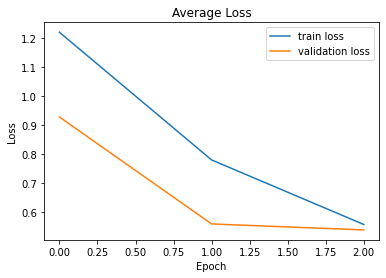

In [34]:
# plot loss history
plt.plot(train_history.history['loss'], label='train loss')
plt.plot(train_history.history['val_loss'], label='validation loss')
plt.title('Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

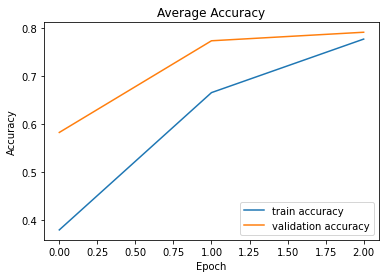

In [35]:
# plot accuracy history
plt.plot(train_history.history['accuracy'], label='train accuracy')
plt.plot(train_history.history['val_accuracy'], label='validation accuracy')
plt.title('Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the above plots we can clearly see that the gap between the training and validation losses has decreased by a large margin and best validation accuracy with XLM-RoBERTa model is 79-80%.

To further evaluate the performance of the XLM-RoBERTa model, we'll generate the confusion matrix and classification report on the validation data.


Classification Report
               precision    recall  f1-score   support

contradiction       0.91      0.74      0.82       813
   entailment       0.80      0.81      0.81       835
      neutral       0.69      0.82      0.75       776

     accuracy                           0.79      2424
    macro avg       0.80      0.79      0.79      2424
 weighted avg       0.80      0.79      0.79      2424



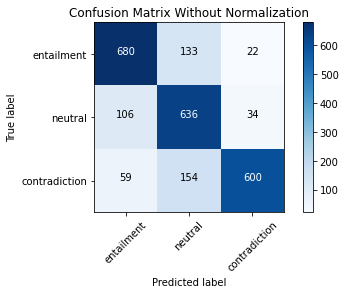

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

# The function plot_confusion_matrix() is from scikit-learn’s website to plot the confusion matrix. 
# link: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


validation_predictions = [np.argmax(i) for i in model.predict(validation_input)] #predictions
validation_labels = validation.label.values.tolist() #ground truth labels

cm_plot_labels = ['entailment','neutral', 'contradiction']
cm = confusion_matrix(y_true=validation_labels, y_pred=validation_predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix Without Normalization')
# plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix With Normalization', normalize=True)

target_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_labels]
prediction_class = ['entailment' if label==0 else 'neutral' if label==1 else 'contradiction' for label in validation_predictions]
print('\nClassification Report')
print(classification_report(y_true=target_class, y_pred=prediction_class))

It would also be interesting to look at the number of correct predictions per language.

In [37]:
# function to print accuracy per language
def accuracy(x):
    return round(float(x[2]/x[1]), 2)*100

validation['predictions'] = validation_predictions

# Calculate the total number of examples per language
lang_counts = validation.language.value_counts().sort_index()

# Calculate the number of correct predictions per language
tp_per_lang = validation[validation['label'] == validation['predictions']].groupby('language').agg({'language': ['count']}).sort_index()

lang_names = lang_counts.index.tolist()
lang_tuples = list(zip(lang_names, lang_counts.values.tolist(), tp_per_lang.iloc[:, 0].values.tolist()))
acc = map(accuracy, lang_tuples)
for i, score in enumerate(acc):
    print ("Accuracy of {} is {} ".format(lang_tuples[i][0], score))

Accuracy of Arabic is 82.0 
Accuracy of Bulgarian is 79.0 
Accuracy of Chinese is 81.0 
Accuracy of English is 82.0 
Accuracy of French is 76.0 
Accuracy of German is 75.0 
Accuracy of Greek is 77.0 
Accuracy of Hindi is 67.0 
Accuracy of Russian is 76.0 
Accuracy of Spanish is 82.0 
Accuracy of Swahili is 65.0 
Accuracy of Thai is 68.0 
Accuracy of Turkish is 72.0 
Accuracy of Urdu is 76.0 
Accuracy of Vietnamese is 85.0 


# Generate Predictions on Test Data

Once we are satisfied with our model's performance, we can get test-data predictions for submission.

In [38]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [39]:
#encode the test-input sequences
test_input = encode(test, tokenizer=tokenizer, max_len=MAX_LEN)

Encoding...
Complete


In [40]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
# predictions = predictions[:test.shape[0]]

# Submit the Predictions

In [41]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0


In [42]:
submission.to_csv("submission.csv", index = False)

That's it! The submission file has been created, for more information on how to submit to the competition, please visit the following [link](https://www.kaggle.com/c/contradictory-my-dear-watson/overview/evaluation).




<span style="color:blue">If you found this notebook helpful, please kindly upvote!</span>